Kullanılan Cihaz: cuda


100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s] 


Eğitim Başlıyor...
Epoch [1/15], Loss: 0.0179
Epoch [2/15], Loss: 0.0075
Epoch [3/15], Loss: 0.0064
Epoch [4/15], Loss: 0.0060
Epoch [5/15], Loss: 0.0054
Epoch [6/15], Loss: 0.0051
Epoch [7/15], Loss: 0.0049
Epoch [8/15], Loss: 0.0048
Epoch [9/15], Loss: 0.0047
Epoch [10/15], Loss: 0.0046
Epoch [11/15], Loss: 0.0045
Epoch [12/15], Loss: 0.0044
Epoch [13/15], Loss: 0.0044
Epoch [14/15], Loss: 0.0043
Epoch [15/15], Loss: 0.0043


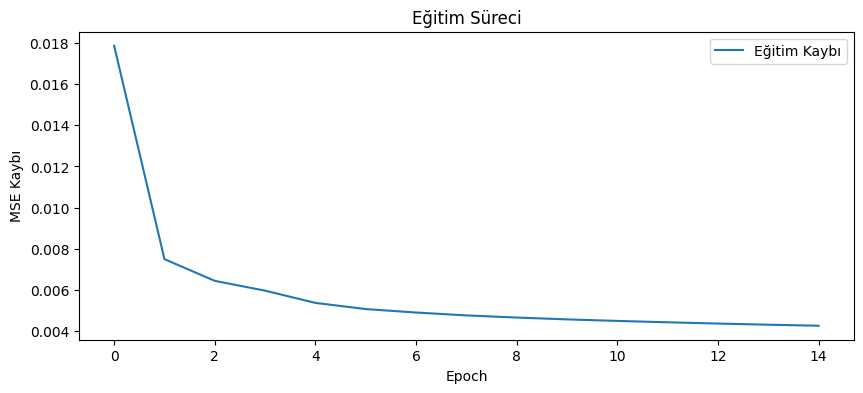

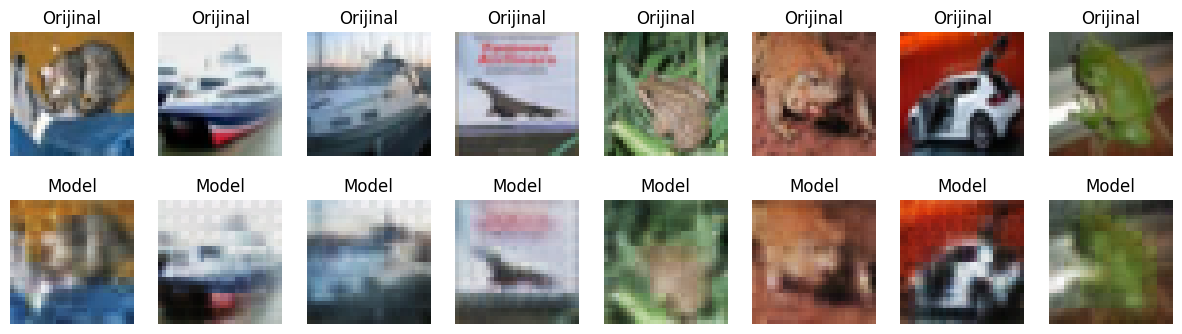

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Ayarlar ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15

# --- 2. Veri Hazırlığı (CIFAR-10) ---
transform = transforms.Compose([
    transforms.ToTensor(), 
    # Normalizasyon (Opsiyonel ama önerilir, burada basitlik için [0,1] arası bırakıyoruz)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. Evrişimli Autoencoder Modeli (CAE) ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # --- ENCODER (Küçültme) ---
        # Girdi: (Batch, 3, 32, 32)
        self.encoder = nn.Sequential(
            # Katman 1
            nn.Conv2d(3, 12, kernel_size=3, padding=1), # Boyut değişmez: (12, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Boyut yarılanır: (12, 16, 16)
            
            # Katman 2
            nn.Conv2d(12, 24, kernel_size=3, padding=1), # Boyut değişmez: (24, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Boyut yarılanır: (24, 8, 8)
            # Bottleneck (Gizli Alan) burasıdır: 24 kanal x 8x8 piksel
        )
        
        # --- DECODER (Büyütme) ---
        # Girdi: (Batch, 24, 8, 8)
        self.decoder = nn.Sequential(
            # Katman 1 (Tersine İşlem)
            # ConvTranspose2d stride=2 ile boyutu 2 katına çıkarır
            nn.ConvTranspose2d(24, 12, kernel_size=2, stride=2), # (12, 16, 16)
            nn.ReLU(),
            
            # Katman 2
            nn.ConvTranspose2d(12, 3, kernel_size=2, stride=2), # (3, 32, 32)
            nn.Sigmoid() # Çıktıyı [0, 1] arasına sıkıştır (Görüntü formatı için)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- 4. Eğitim Döngüsü ---
print("Eğitim Başlıyor...")
loss_history = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for data in train_loader:
        img, _ = data # Etiketlere (uçak, kedi vs.) ihtiyacımız yok
        img = img.to(device)
        
        # Forward
        output = model(img)
        loss = criterion(output, img) # Girdi = Hedef
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * img.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

# --- 5. Sonuçları Görselleştirme ---
# Kayıp grafiği
plt.figure(figsize=(10, 4))
plt.plot(loss_history, label='Eğitim Kaybı')
plt.title("Eğitim Süreci")
plt.xlabel("Epoch")
plt.ylabel("MSE Kaybı")
plt.legend()
plt.show()

# Görüntü Karşılaştırması
model.eval()
with torch.no_grad():
    # Test setinden bir grup al
    images, _ = next(iter(test_loader))
    images = images.to(device)
    
    # Modelden geçir
    outputs = model(images)
    
    # CPU'ya al ve görselleştir
    images = images.cpu()
    outputs = outputs.cpu()
    
    # İlk 8 görüntüyü çiz
    n = 8
    plt.figure(figsize=(15, 4))
    for i in range(n):
        # Orijinal
        ax = plt.subplot(2, n, i + 1)
        # CIFAR görüntüleri (3, 32, 32) formatındadır. 
        # Matplotlib (32, 32, 3) ister, bu yüzden permute kullanıyoruz.
        plt.imshow(images[i].permute(1, 2, 0)) 
        plt.title("Orijinal")
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(outputs[i].permute(1, 2, 0))
        plt.title("Model")
        plt.axis('off')
    plt.show()